# Package

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import libpysal as lps
from esda import moran
from splot import esda
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR


# Data Import

In [2]:
crime  = pd.read_csv('data/crime2021.csv')
crime.dropna(subset=['Longitude', 'Latitude'], inplace=True)
crime_gdf = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime['Longitude'], crime['Latitude']), crs='epsg:4326')
crime_gdf.drop(columns=['Longitude', 'Latitude'], inplace=True)
crime_gdf.head()

,Crime ID,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry
0,83da2d94838f010f645244f915376fe87a8629abf5c47b...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Parklands Drive,E01019087,Allerdale 007D,Vehicle crime,Under investigation,NaN,POINT (-3.37605 54.66306)
1,9348af7f46329886ab9a42482d860e346da42483048a26...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near South Terrace,E01031400,Arun 011A,Violence and sexual offences,Under investigation,NaN,POINT (-0.53568 50.80415)
2,6601ff35897e249d0b5492b7787304256a760c13bf1503...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Coldicott Mews,E01031440,Arun 013D,Violence and sexual offences,Under investigation,NaN,POINT (-0.60563 50.79223)
3,e4e622a6600bc2aec6949242c2b60c61694539b77167d6...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Steeds Lane,E01024034,Ashford 010D,Violence and sexual offences,Under investigation,NaN,POINT (0.86969 51.10827)
4,1ad4d07e77a9ad580cb7504476d7f8f85c95bfdcf0d11c...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Marshalls Lea,E01017641,Aylesbury Vale 007A,Violence and sexual offences,Under investigation,NaN,POINT (-0.77786 51.82937)


In [3]:
lsoas = gpd.read_file('data/LDN-LSOAs/LDN-LSOAs.shp')
lsoas.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18..."
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18..."
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18..."
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18..."


In [4]:
imd = pd.read_csv('data/IoD2019_Transformed_Scores.csv')
imd.columns=['LSOA11CD', 'LSOANM', 'LADCD', 'LADNM', 'Income', 'Employment', 'Education', 'Health', 'Crime', 'Barriers', 'Environment']
imd.head()

,LSOA11CD,LSOANM,LADCD,LADNM,Income,Employment,Education,Health,Crime,Barriers,Environment
0,E01000001,City of London 001A,E09000001,City of London,0.010,0.071,0.002,0.512,0.127,33.518,32.163
1,E01000002,City of London 001B,E09000001,City of London,2.131,1.173,0.009,2.280,0.039,23.197,20.749
2,E01000003,City of London 001C,E09000001,City of London,12.962,17.523,4.964,14.094,2.542,58.754,45.907
3,E01000005,City of London 001E,E09000001,City of London,37.706,32.041,21.974,13.706,1.269,58.227,28.053
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.180,9.390,14.208,9.505,12.555,71.868,25.337


In [5]:
popden = pd.read_csv('data/popden2020.csv')
popden.head()

,LSOA Code,LSOA Name,Mid-2020 population,Area Sq Km,People per Sq Km
0,E01011949,Hartlepool 009A,1944,0.52,3746
1,E01011950,Hartlepool 008A,1298,0.13,9796
2,E01011951,Hartlepool 007A,1208,0.21,5791
3,E01011952,Hartlepool 002A,1724,0.46,3715
4,E01011953,Hartlepool 002B,2026,0.88,2294


# Data Preprocess

In [6]:
drug_crime = crime_gdf.loc[crime_gdf['Crime type']=='Drugs']
drug_crime = drug_crime.to_crs(epsg=27700)

In [7]:
drug_lsoa = gpd.sjoin(drug_crime, lsoas, how='inner')
drug_lsoa.head()

,Crime ID,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,index_right,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths
47,b1471f9bec122c4582675215d0054bb7ce68cf02848a58...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Woodrush Way,E01000029,Barking and Dagenham 001C,Drugs,Local resolution,NaN,POINT (547669.197 189253.798),26,E01000029,Barking and Dagenham 001C,Barking and Dagenham 001C,27,253013.784898,3827.079919
48,af1927f416568d62e6ed6aab326792e678f1b84cfae8e1...,2021-09,Metropolitan Police Service,Metropolitan Police Service,On or near Eastern Avenue,E01000029,Barking and Dagenham 001C,Drugs,Awaiting court outcome,NaN,POINT (547912.200 189066.780),26,E01000029,Barking and Dagenham 001C,Barking and Dagenham 001C,27,253013.784898,3827.079919
92357,f10c8b98c3d4d5aba606921dd5bd49dfca3a8de874fe43...,2021-07,Metropolitan Police Service,Metropolitan Police Service,On or near Havering Gardens,E01000029,Barking and Dagenham 001C,Drugs,Offender given a caution,NaN,POINT (547989.196 188989.784),26,E01000029,Barking and Dagenham 001C,Barking and Dagenham 001C,27,253013.784898,3827.079919
368775,9d4cfbeaa64c29f8f1e8702b628b67e5518da3cc1a3c75...,2021-08,Metropolitan Police Service,Metropolitan Police Service,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Drugs,Local resolution,NaN,POINT (548339.159 188932.777),26,E01000029,Barking and Dagenham 001C,Barking and Dagenham 001C,27,253013.784898,3827.079919
458014,1992cf028e026cf720d9c2a28c2e4529e093d353ab06ed...,2021-12,Metropolitan Police Service,Metropolitan Police Service,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Drugs,Local resolution,NaN,POINT (548339.159 188932.777),26,E01000029,Barking and Dagenham 001C,Barking and Dagenham 001C,27,253013.784898,3827.079919


In [8]:
df_count = drug_lsoa.groupby('lsoa11cd').size().to_frame(name='count').reset_index()
drug_lsoa = lsoas.merge(df_count, on='lsoa11cd', how='left')
drug_lsoa.fillna(0, inplace=True)
drug_lsoa.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,count
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",12.0
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",15.0
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.0
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18...",70.0
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18...",15.0


In [9]:
drug_lsoa = drug_lsoa.merge(imd, left_on='lsoa11cd', right_on='LSOA11CD', how='left')
drug_lsoa.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,count,LSOA11CD,LSOANM,LADCD,LADNM,Income,Employment,Education,Health,Crime,Barriers,Environment
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",12.0,E01000001,City of London 001A,E09000001,City of London,0.010,0.071,0.002,0.512,0.127,33.518,32.163
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",15.0,E01000002,City of London 001B,E09000001,City of London,2.131,1.173,0.009,2.280,0.039,23.197,20.749
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.0,E01000003,City of London 001C,E09000001,City of London,12.962,17.523,4.964,14.094,2.542,58.754,45.907
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18...",70.0,E01000005,City of London 001E,E09000001,City of London,37.706,32.041,21.974,13.706,1.269,58.227,28.053
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18...",15.0,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.180,9.390,14.208,9.505,12.555,71.868,25.337


In [10]:
drug_lsoa = drug_lsoa.merge(popden[['LSOA Code', 'Mid-2020 population']], left_on='lsoa11cd', right_on='LSOA Code', how='left')
drug_lsoa['crime_rate'] = drug_lsoa['count']/(drug_lsoa['Mid-2020 population']/1000)
drug_lsoa.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,count,LSOA11CD,LSOANM,...,Income,Employment,Education,Health,Crime,Barriers,Environment,LSOA Code,Mid-2020 population,crime_rate
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",12.0,E01000001,City of London 001A,...,0.010,0.071,0.002,0.512,0.127,33.518,32.163,E01000001,1749,6.861063
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",15.0,E01000002,City of London 001B,...,2.131,1.173,0.009,2.280,0.039,23.197,20.749,E01000002,1678,8.939213
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.0,E01000003,City of London 001C,...,12.962,17.523,4.964,14.094,2.542,58.754,45.907,E01000003,1900,0.000000
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18...",70.0,E01000005,City of London 001E,...,37.706,32.041,21.974,13.706,1.269,58.227,28.053,E01000005,2181,32.095369
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18...",15.0,E01000006,Barking and Dagenham 016A,...,19.180,9.390,14.208,9.505,12.555,71.868,25.337,E01000006,2117,7.085498


In [11]:
drug_lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   lsoa11cd             4835 non-null   object  
 1   lsoa11nm             4835 non-null   object  
 2   lsoa11nmw            4835 non-null   object  
 3   objectid             4835 non-null   int64   
 4   st_areasha           4835 non-null   float64 
 5   st_lengths           4835 non-null   float64 
 6   geometry             4835 non-null   geometry
 7   count                4835 non-null   float64 
 8   LSOA11CD             4835 non-null   object  
 9   LSOANM               4835 non-null   object  
 10  LADCD                4835 non-null   object  
 11  LADNM                4835 non-null   object  
 12  Income               4835 non-null   float64 
 13  Employment           4835 non-null   float64 
 14  Education            4835 non-null   float64 
 15  Health       

<AxesSubplot:>

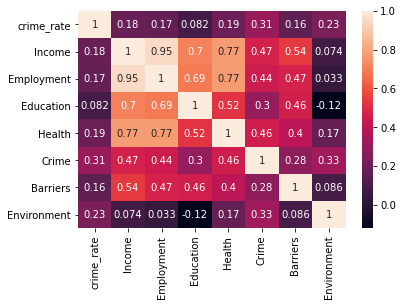

In [12]:
X  = drug_lsoa[['crime_rate', 'Income', 'Employment', 'Education', 'Health', 'Crime', 'Barriers', 'Environment']]
corr = X.corr()
sns.heatmap(corr, annot=True)

In [13]:
X = X.drop(columns=['crime_rate', 'Income'])
df_vif = X.assign(const=1)
vif_res = pd.Series([variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)
vif_res

Employment     3.633261
Education      2.096797
Health         2.688778
Crime          1.451791
Barriers       1.369178
Environment    1.241574
const          8.452648
dtype: float64

# OLS

In [14]:
y = drug_lsoa['crime_rate']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             crime_rate   R-squared (uncentered):                   0.363
Model:                            OLS   Adj. R-squared (uncentered):              0.362
Method:                 Least Squares   F-statistic:                              459.2
Date:                Tue, 19 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:13:06   Log-Likelihood:                         -16063.
No. Observations:                4835   AIC:                                  3.214e+04
Df Residuals:                    4829   BIC:                                  3.218e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Employment      0.0191      0.014      1.410      0.159      -0.007       0.046
Education      -0.0406      0.013     -3.026      0.002      -0.067      -0.014
Health          0.0184      0.015      1.239      0.216      -0.011       0.048
Crime           0.0965      0.007     13.474      0.000       0.082       0.111
Barriers        0.0160      0.005      3.311      0.001       0.007       0.025
Environment     0.0481      0.006      8.344      0.000       0.037       0.059
==============================================================================
Omnibus:                     9812.818   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44325280.192
Skew:                          16.489   Prob(JB):                         0.00
Kurtosis:                     470.904   Cond. No.                         12.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     111.6
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          2.88e-132
Time:                        15:13:07   Log-Likelihood:                -16053.
No. Observations:                4835   AIC:                         3.212e+04
Df Residuals:                    4828   BIC:                         3.216e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2629      0.280     -4.509      0.000      -1.812      -0.714
Employment      0.0221      0.014      1.630      0.103      -0.004       0.049
Education      -0.0290      0.014     -2.130      0.033      -0.056      -0.002
Health          0.0124      0.015      0.834      0.405      -0.017       0.042
Crime           0.1007      0.007     13.962      0.000       0.087       0.115
Barriers        0.0244      0.005      4.728      0.000       0.014       0.035
Environment     0.0665      0.007      9.429      0.000       0.053       0.080
==============================================================================
Omnibus:                     9786.394   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43971665.641
Skew:                          16.385   Prob(JB):                         0.00
Kurtosis:                     469.040   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Moran

In [17]:
weights = lps.weights.Queen.from_dataframe(drug_lsoa)
mor = moran.Moran(drug_lsoa['crime_rate'], weights)
print(f'Global Moran\'s I: {mor.I}')
print(f'P value: {mor.p_sim}')
print(f'Expected Moran\'s I under null hypothesis: {mor.EI}')
print(f'Z score: {mor.z_sim}')

Global Moran's I: 0.29868850531869207
P value: 0.001
Expected Moran's I under null hypothesis: -0.0002068680182043856
Z score: 37.269146802141016


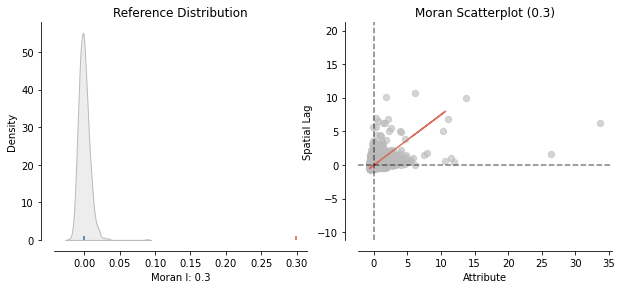

In [20]:
fig, ax = esda.plot_moran(mor, zstandard=True, figsize=(10,4))
# plt.savefig('fig/globalmoran.png', dpi=200)
plt.show()

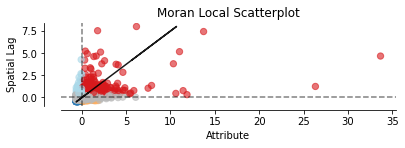

In [21]:
mor_local = moran.Moran_Local(drug_lsoa['crime_rate'], weights)
fig, ax = plt.subplots()
esda.moran_scatterplot(mor_local, p=0.05, ax=ax)
# plt.savefig('fig/localmoran.png', dpi=300)
plt.show()

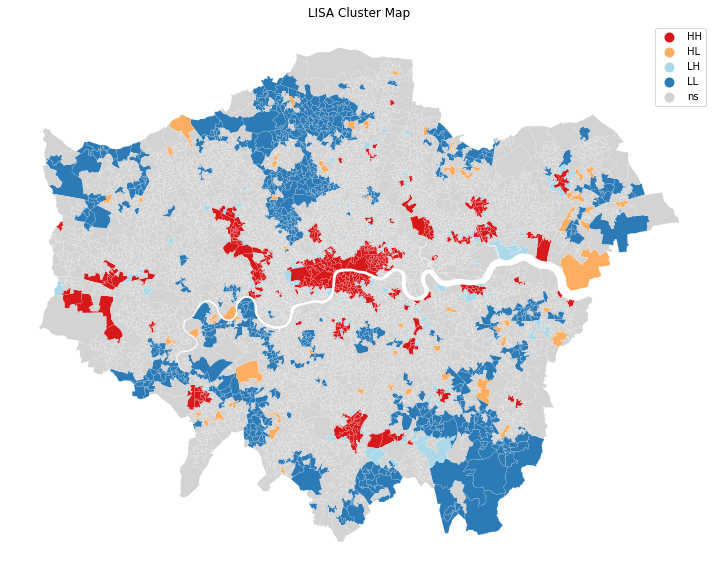

In [22]:
fig, ax=plt.subplots(1, figsize=(14,10))
fig = esda.lisa_cluster(mor_local, drug_lsoa, ax=ax)
plt.title("LISA Cluster Map")
plt.show()

# GWR

In [38]:
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = drug_lsoa['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [34]:
g_y = drug_lsoa['crime_rate'].values.reshape(-1,1)
g_X = X.drop(columns=['const']).values
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [40]:
bw = Sel_BW(coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=False) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)

81.0

In [41]:
gwr_selector = Sel_BW(coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
results = GWR(coords, g_y, g_X, gwr_bw).fit()

81.0


In [42]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4246.038
Log-likelihood:                                                   -6546.547
AIC:                                                              13107.095
AICc:                                                             13109.125
BIC:                                                             -36712.958
R2:                                                                   0.122
Adj. R2:                                                              0.121

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------